In this notebook, we are going to use [`Unet`](https://arxiv.org/abs/1505.04597) to segment images from solar panels. The dataset used in notebook was [this dataset](https://www.kaggle.com/datasets/salimhammadi07/solar-panel-detection-and-identification) from [@salimhammadi07](https://www.kaggle.com/salimhammadi07).

Instead of building the model from scratch, we will use `segmentation_models` module. You can find more about it in their [Github Repository](https://github.com/qubvel/segmentation_models).

First, we explore the dataset a little bit, then go through preprocessing process. Lastly, we will build and train the model using `ResNet50` as the backbone of the `UNet`.

So let's get started!

# I. Explore Dataset 🔍

In [1]:
pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.2 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.3-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.7 MB/s eta 0:00:00:00:0100:01
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flatbuffers-24.3.25-py2.py3-none-any.w

In [1]:
pip install tensorflow==2.10.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
%%capture
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-07-15 02:51:44.875887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 02:51:45.027600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-15 02:51:45.027623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-15 02:51:45.065833: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 02:51:47.017208: W tensorflow/stream_executor/pla

The dataset is divided into several directories based on the location the image is taken, following code will show the number of all images in each directory.

In [3]:
root_path = "/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03" 
categories_paths = os.listdir(root_path)
categories_paths = [os.path.join(root_path, cat_path) for cat_path in categories_paths]

In [4]:
for cat_path in categories_paths:
    for _, _, files in os.walk(cat_path):
        print("{}: {}".format(cat_path, len(files)))

/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Cropland: 1718
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/.ipynb_checkpoints: 0
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Shrubwood: 238
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_WaterSurface: 1250
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/train: 2308
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Grassland: 234
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/input: 5
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/input: 2
/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_SalineAlkali: 704
/home/jovyan/shared/Learning materials/subsections/1.*/code

Let us see an instance of the dataset and its mask:

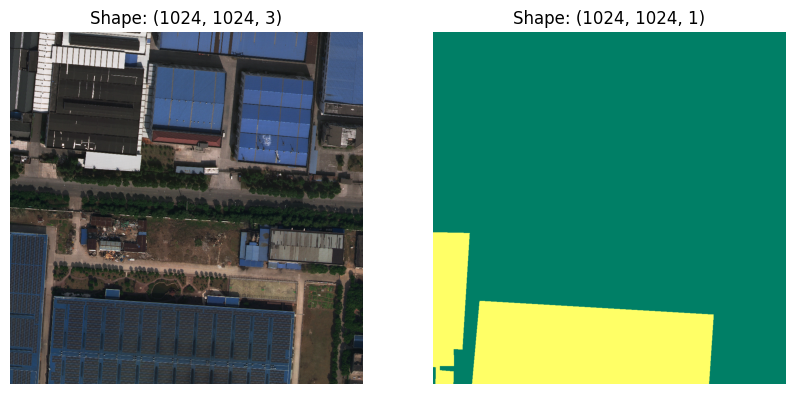

In [5]:
image_path = '/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Rooftop/PV03_316370_1203802.bmp'
mask_path = '/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Rooftop/PV03_316370_1203802_label.bmp'
image = plt.imread(image_path)
mask = np.expand_dims(plt.imread(mask_path), axis=(-1))
image_shape = image.shape
mask_shape = mask.shape

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

axes[0].imshow(image)
axes[0].set_title('Shape: ' + str(image_shape))

axes[1].imshow(mask, cmap="summer")
axes[1].set_title('Shape: ' + str(mask_shape))

[ax.axis("off") for ax in axes]
plt.show()

All image are 1024x1024 pixels which will be huge for our model. The masks are in binary format, 1 for solar panels and 0 for other things.
So we need to take this considerations:
* Down-sampling images for ease of training.
* We need just one neuron in the output layer of our model which tells probabilty of being solar panel.
* Due to high resolution of the images, we cannot fit all of the dataset in RAM so creating the dataset from a generator is necessary.

# II. Dataset Preparation 🖇

In this part, we should take care of several things:
* Creating a generator to read images from memory on the fly (during training).
* Spliting the dataset into train and test for further evaluation.
* Creating two datasets from the generators

In [6]:
images_paths = []
for cat_path in categories_paths:
    for root, _, files in os.walk(cat_path):
        cd_images = [os.path.join(root, file) for file in files]
        [images_paths.append(img) for img in cd_images]
images_paths = sorted(images_paths)
images_paths[:6]

['/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Cropland/PV03_314875_1196456.bmp',
 '/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Cropland/PV03_314875_1196456_label.bmp',
 '/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Cropland/PV03_314902_1196424.bmp',
 '/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Cropland/PV03_314902_1196424_label.bmp',
 '/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Cropland/PV03_314902_1196456.bmp',
 '/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/PV03_Ground_Cropland/PV03_314902_1196456_label.bmp']

We can see that the images are in the odd indices and their mask is in the next index, so knowing this structure, we will divide the indices to `train_idx` and `test_idx` and then create these generators:

In [7]:
n_images = len(images_paths)
new_size = (256, 256)
images_idx = range(0, n_images, 2)
train_idx, test_idx = train_test_split(images_idx, test_size=0.15)

In [8]:
def train_dataset_generator():
    for i in train_idx:
        image = (
            tf.convert_to_tensor(plt.imread(images_paths[i]), dtype=tf.float32) / 255.0
        )
        mask = (
            tf.convert_to_tensor(
                np.expand_dims(plt.imread(images_paths[i + 1]), axis=(-1)),
                dtype=tf.float32,
            )
            / 255.0
        )

        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)

        yield image, mask
        

def test_dataset_generator():
    for i in test_idx:
        image = (
            tf.convert_to_tensor(plt.imread(images_paths[i]), dtype=tf.float32) / 255.0
        )
        mask = (
            tf.convert_to_tensor(
                np.expand_dims(plt.imread(images_paths[i + 1]), axis=(-1)),
                dtype=tf.float32,
            )
            / 255.0
        )

        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)

        yield image, mask

Okay, let's have the tensorflow's datasets:

In [22]:
train_dataset = tf.data.Dataset.from_generator(
    train_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(*new_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*new_size, 1), dtype=tf.float32),
    ),
)

test_dataset = tf.data.Dataset.from_generator(
    test_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(*new_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*new_size, 1), dtype=tf.float32),
    ),
)


Next, we wil check if the dataset is working properly or not.

In [23]:
def show_images(images, titles=None):
    if not titles:
        titles = [img.shape for img in images]
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(10, 30))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="summer")
        ax.set_title(titles[i])
        ax.axis("off")
    plt.show()

In [24]:
for item in train_dataset.take(1):
    show_images(item)

2024-07-15 02:58:50.137351: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (256, 256, 1) where an element of shape (256, 256, 3) was expected.
Traceback (most recent call last):

  File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 1) where an element of shape (256, 256, 3) was expected.




InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element of shape (256, 256, 1) where an element of shape (256, 256, 3) was expected.
Traceback (most recent call last):

  File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 1) where an element of shape (256, 256, 3) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [25]:
import tensorflow as tf
import numpy as np

def train_dataset_generator():
    while True:
        # Generate or load your image
        image = np.random.rand(256, 256, 1).astype(np.float32)  # Example random grayscale image
        image = np.repeat(image, 3, axis=-1)  # Convert to RGB by repeating the grayscale channel
        label = np.random.rand(256, 256, 1).astype(np.float32)  # Example random label
        yield image, label

train_dataset = tf.data.Dataset.from_generator(
    train_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),  # Changed shape to (256, 256, 3)
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)
    )
)

train_dataset = train_dataset.batch(32)

# Checking the shapes of the yielded data
for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)  # Should be (batch_size, 256, 256, 3)
    print("Label batch shape:", label_batch.shape)  # Should be (batch_size, 256, 256, 1)


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 256, 256, 1)


Great! The dataset is prepared for going through training. Note that the instances are resized and rescaled in the previous code cells.

With that being said, let's go to get to know the model in the next part.

# III. UNet Model ⚓

The model used in this notebook is UNet. UNet architecture has two major parts: a contracting part for capturing context and a symmetric expanding path for enabling precise localization. You can see the architecture of the original UNet model in the following image:
![UNet Architecure](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Please note that, we won't use exactly this architecture; Backbone of our model will be `ResNet50` as you can see in the following code cells:

In [12]:
pip install segmentation-models

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip list

Package                      Version      Editable project location
---------------------------- ------------ ----------------------------------------------------------
absl-py                      2.1.0
addict                       2.4.0
affine                       2.4.0
aliyun-python-sdk-core       2.14.0
aliyun-python-sdk-kms        2.16.2
asttokens                    2.4.1
astunparse                   1.6.3
attrs                        23.2.0
branca                       0.7.2
Brotli                       1.1.0
cachetools                   5.3.3
census                       0.8.21
certifi                      2023.11.17
cffi                         1.16.0
charset-normalizer           3.3.2
chex                         0.1.86
click                        8.1.7
click-plugins                1.1.1
cligj                        0.7.2
cloudpickle                  3.0.0
colorama                     0.4.6
comm                         0.1.4
config                       0.5.1
contourpy      

In [14]:
%%capture
!pip install -U -q segmentation-models

os.environ["SM_FRAMEWORK"] = "tf.keras"
load_model = False
backbone = 'resnet50'
batch_size = 16

import segmentation_models as sm

In [ ]:
pip uninstall efficientnet segmentation-models keras tensorflowY

Before going into training we need to make sure:
* The data is preprocessed regard to the backbone model.
* The dataset is splitted into train and validation dataset.
* The encoder part of the UNet is freezed so the model can be trained within a reasonable time frame.

In [15]:
backbone_preprocess = sm.get_preprocessing(backbone)
preprocess_fn = lambda x, y: (backbone_preprocess(x), y)

train_dataset = train_dataset.map(preprocess_fn)

In [16]:
def is_test(x, _):
    return x % 4 == 0

def is_train(x, y):
    return not is_test(x, y)


recover = lambda x, y: y

valid_dataset = train_dataset.enumerate().filter(is_test).map(recover).batch(batch_size)

train_dataset = train_dataset.enumerate().filter(is_train).map(recover).batch(batch_size)

2024-07-15 02:53:13.849726: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-07-15 02:53:13.902031: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [17]:
model = sm.Unet(
    backbone,
    classes=1,
    encoder_weights="imagenet",
    encoder_freeze=True,
)
model.compile("Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
# keras.utils.plot_model(model, show_shapes=True) # Uncomment for seeing the model graph, it is HUGE!

94592056/94592056 [==============================] - 4s 0us/step


# IV. Training Model 🌠

In this part we will train the model.
First we define a callback for visualize the learning process with one instance of the training dataset. 

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            for item in train_dataset.unbatch().shuffle(1).take(1):
                image = item[0]
                mask_4d = self.model.predict(np.expand_dims(image, axis=(0)))
                mask = np.squeeze(mask_4d, axis=0)
                show_images((image, mask))

display_cb = DisplayCallback()
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights='True')

In the following code cell, we will decide to train the model from scratch or load the model in case we hava trained it previously:

In [27]:
if load_model:
    model_path = "/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/input/solar-panel-model/model_1.h5"
    history_path = "/home/jovyan/shared/Learning materials/subsections/1.*/code/data/kaggle_solar/PV03/input/solar-panel-model/history.csv"
    model = keras.models.load_model(
        model_path,
        custom_objects={
            "binary_crossentropy_plus_jaccard_loss": sm.losses.bce_jaccard_loss,
            "iou_score": sm.metrics.iou_score,
        },
    )
    history = pd.read_csv(history_path)
else:
    with tf.device("/device:GPU:0"):
        history = model.fit(
            train_dataset,
            batch_size=batch_size,
            epochs=100,
            validation_data=valid_dataset,
            callbacks=[display_cb, early_stopping_cb],
        )
    history = pd.DataFrame.from_dict(history.history)

    history.to_csv("history_unet-mobilnetv2.csv", index=False)
    model.save("model_unet-mobilnetv2.h5")


Epoch 1/100


ValueError: in user code:

    File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_3" "                 f"(type Functional).
    
    Input 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 256, 256, 3)
    
    Call arguments received by layer "model_3" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
      • training=True
      • mask=None


Let's take a look on train and validation loss and IoU score:

NameError: name 'history' is not defined

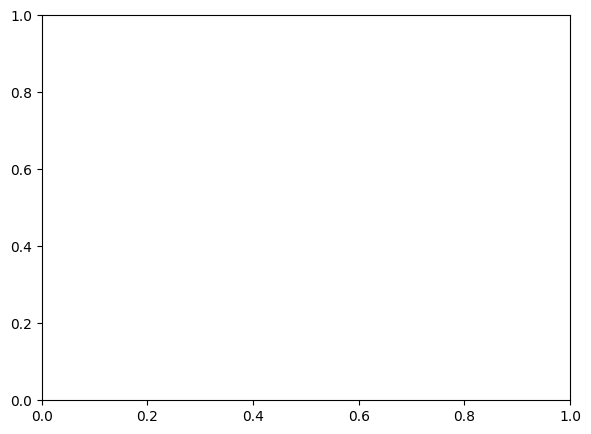

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['iou_score'])
plt.plot(history['val_iou_score'])
plt.title('model IoU score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# V. Evaluate Model 🧪

In the last part of this notebook, we will evaluate the model. For doing this, first we will take 10 instances from test set and see the result, note that these predictions are clean meaning the model never seen these imgaes.
Also there is a fine detail, the model will predict the probability of a pixel being target, we should set a threshold to decide it is 0 or 1. We could have a layer to the model itself to do this chore but in this way we can see both probabilties and the final result.

1/1 [==============================] - 0s 41ms/step


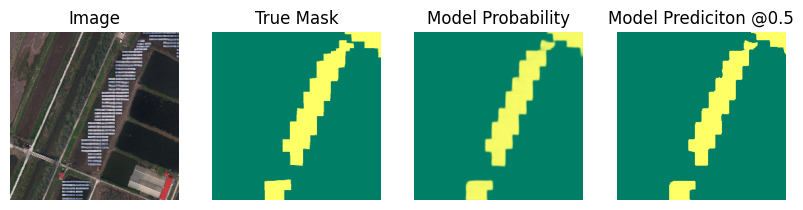

1/1 [==============================] - 0s 37ms/step


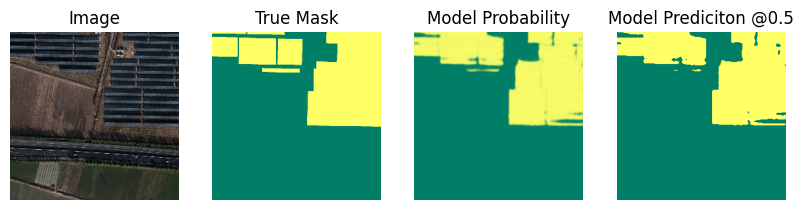

1/1 [==============================] - 0s 34ms/step


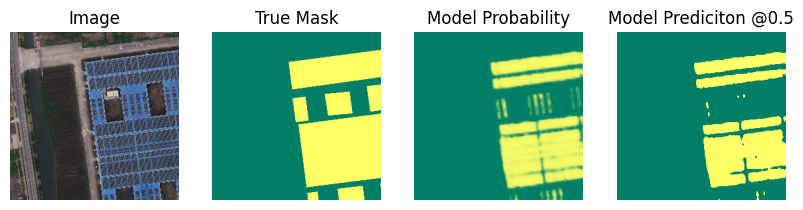

1/1 [==============================] - 0s 52ms/step


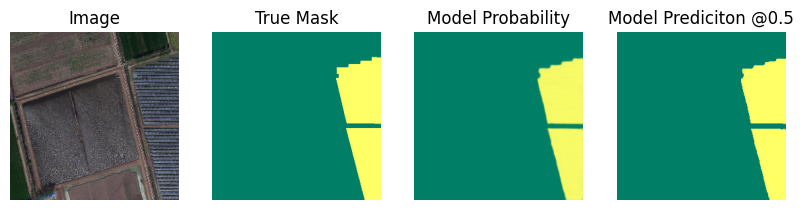

1/1 [==============================] - 0s 36ms/step


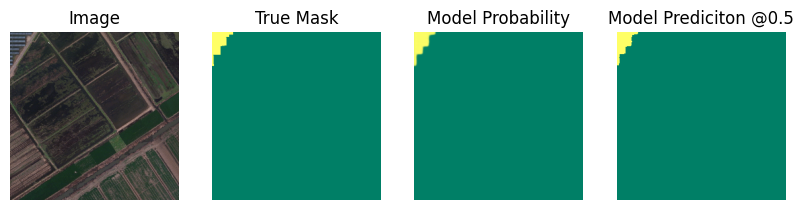

1/1 [==============================] - 0s 44ms/step


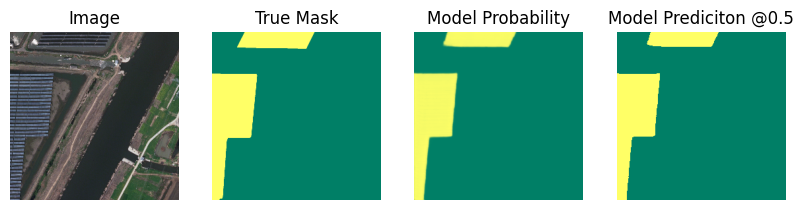

1/1 [==============================] - 0s 38ms/step


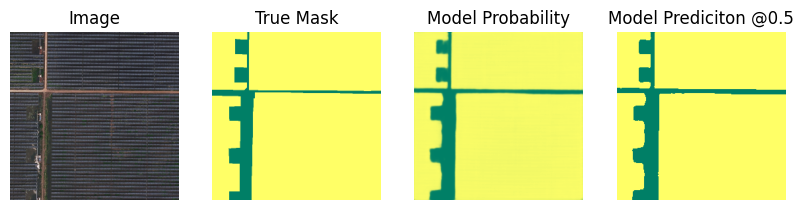

1/1 [==============================] - 0s 50ms/step


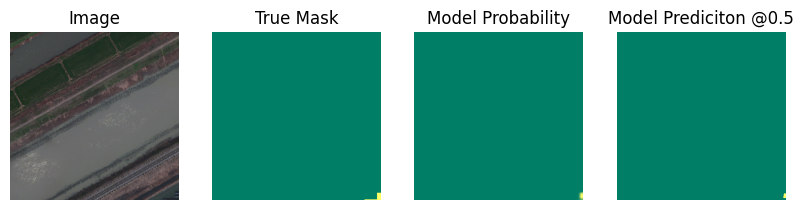

1/1 [==============================] - 0s 42ms/step


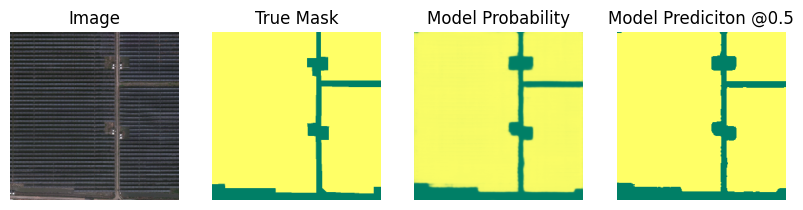

1/1 [==============================] - 0s 35ms/step


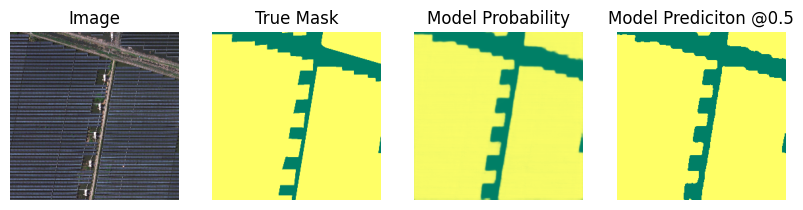

In [18]:
threshold = 0.5

for item in test_dataset.shuffle(10).take(10):
        image = item[0]
        true_mask = item[1]
        mask_4d = model.predict(np.expand_dims(image, axis=(0)))
        pred_mask_proba = np.squeeze(mask_4d, axis=0)
        pred_mask = np.where(pred_mask_proba > threshold, 1, 0)
        
        show_images((image, true_mask, pred_mask_proba, pred_mask), ["Image", "True Mask", "Model Probability", "Model Prediciton @0.5"])

In [19]:
model.evaluate(test_dataset.batch(batch_size))

22/22 [==============================] - 23s 1s/step - loss: 0.8864 - iou_score: 0.3796


[0.8863972425460815, 0.37961146235466003]